In [1]:
from itertools import product

import graspy
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from graspy.embed import select_dimension, AdjacencySpectralEmbed
from graspy.inference.latent_distribution_test import _fit_plug_in_variance_estimator
from graspy.inference import LatentDistributionTest
from graspy.simulations import rdpg

from hyppo.ksample import KSample
from hyppo._utils import gaussian

from joblib import Parallel, delayed

from scipy.stats import multivariate_normal
from tqdm import tqdm

import sys
sys.path.append("./align/")
from align.seedless_procrustes import SeedlessProcrustes
from align.sign_flips import SignFlips
from utils import load_data

%matplotlib inline

print(graspy.__version__)

0.3.0


<AxesSubplot:title={'center':'Right'}>

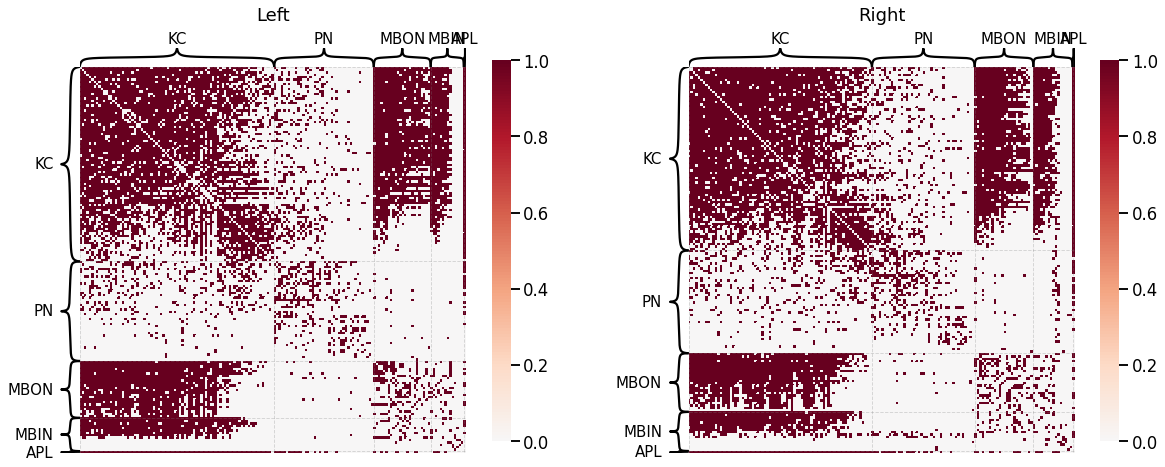

In [2]:
A_l, nodes_l, A_r, nodes_r, hemispheres = load_data()

fig, ax = plt.subplots(1, 2, figsize=(20, 10))
graspy.plot.heatmap(A_l, inner_hier_labels=nodes_l, hier_label_fontsize=15, sort_nodes=True, ax=ax[0], title="Left")
graspy.plot.heatmap(A_r, inner_hier_labels=nodes_r, hier_label_fontsize=15, sort_nodes=True, ax=ax[1], title="Right")

In [3]:
print(A_l.shape, A_r.shape)

(163, 163) (158, 158)


In [11]:
def hypothesis_test(X1, X2, flip):
    tests = [KSample('Dcorr'), KSample('MGC'), KSample('HSic', compute_distance=gaussian)]
    
    if flip == 'median':
        X1_flipped = SignFlips('median').fit_transform(X1, X2)
        
    elif flip == 'seedless':
        X1_flipped = SeedlessProcrustes().fit_transform(X1, X2)
        # Q = SeedlessProcrustes().fit_predict(X1, X2)
        # X1_flipped = X1 @ Q
        # X2_flipped = X2
        
    
    pvals = []
    for test in tests:
        res = test.test(X1_flipped, X2, auto=False)
        pvals.append(res[1])
        
    return pvals

def embed_graphs(A1, A2):
    num_dims1 = select_dimension(A1)[0][-1]
    num_dims2 = select_dimension(A2)[0][-1]
    n_components = max(num_dims1, num_dims2)
    
    ase = AdjacencySpectralEmbed(n_components=n_components, diag_aug=True, check_lcc=False)
    X1_hat = ase.fit_transform(A1)
    X2_hat = ase.fit_transform(A2)
    
    return X1_hat, X2_hat

def run_non_replacement(X1_hat, X2_hat, n_verts_to_perterb, delta, n_sims=500):
    """
    delta is non-negative number
    """
    d = X1_hat.shape[1]
    N = X1_hat.shape[0]
    M = X2_hat.shape[0]
    
    X1_cov = _fit_plug_in_variance_estimator(X1_hat)(X1_hat) / N
    X2_cov = _fit_plug_in_variance_estimator(X2_hat)(X2_hat) / M
    
    def worker():    
        # Sample new latents
        X1_new = []
        verts_to_perterb = np.random.choice(range(N), size=n_verts_to_perterb, replace=False)
        
        for idx in range(N):
            if idx in verts_to_perterb:
                direction = multivariate_normal.rvs(cov=np.eye(d), random_state=np.random.randint(2147483647))
                direction /= np.linalg.norm(direction)
                shift = direction * delta
                
                mean = X1_hat[idx] + shift
            else:
                mean = X1_hat[idx]

            X1_new.append(
                multivariate_normal.rvs(
                    mean,
                    X1_cov[idx], 
                    random_state=np.random.randint(2147483647)
                )
            )
        X1_new = np.array(X1_new)
        X2_new = np.array(
            [
                multivariate_normal.rvs(
                    X2_hat[idx], 
                    X2_cov[idx], 
                    random_state=np.random.randint(2147483647)
                ) for idx in range(M)
            ]
        )
        
        # Sample new graphs
        A1 = rdpg(X1_new, rescale=False)
        A2 = rdpg(X2_new, rescale=False)
        X1_resampled, X2_resampled = embed_graphs(A1, A2)
        
        # Compute pvals
        pvals_median = hypothesis_test(X1_resampled, X2_resampled, "median")
        pvals_seedless = hypothesis_test(X1_resampled, X2_resampled, "seedless")
        
        return np.hstack([pvals_median, pvals_seedless])
    
    res = Parallel(-1, verbose=0)(delayed(worker)() for _ in range(n_sims))
    
    res = np.array(res)
    power = (res <= 0.05).mean(axis=0)
    
    return [n_verts_to_perterb, delta, *power]

def run_replacement(X1_hat, X2_hat, X1_verts, X2_verts, n_verts_to_perterb, delta, n_sims=500):
    """
    delta is non-negative number
    """
    d = X1_hat.shape[1]
    N = X1_hat.shape[0]
    M = X2_hat.shape[0]
    
    X1_cov = _fit_plug_in_variance_estimator(X1_hat)(X1_hat) / N
    X2_cov = _fit_plug_in_variance_estimator(X2_hat)(X2_hat) / M
    
    def worker():    
        # Sample new latents
        X1_new = []
        verts_to_perterb = np.random.choice(range(X1_verts), size=n_verts_to_perterb, replace=False)
        
        X1_idx = np.random.choice(range(N), size=X1_verts, replace=True)
        X2_idx = np.random.choice(range(M), size=X2_verts, replace=True)
        
        X1_hat_replaced = X1_hat[X1_idx]
        X2_hat_replaced = X2_hat[X2_idx]
        
        X1_cov_replaced = X1_cov[X1_idx]
        X2_cov_replaced = X2_cov[X2_idx]
        
        for idx in range(X1_verts):
            if idx in verts_to_perterb:
                direction = multivariate_normal.rvs(cov=np.eye(d), random_state=np.random.randint(2147483647))
                direction /= np.linalg.norm(direction)
                shift = direction * delta
                
                mean = X1_hat_replaced[idx] + shift
            else:
                mean = X1_hat_replaced[idx]

            X1_new.append(
                multivariate_normal.rvs(
                    mean,
                    X1_cov_replaced[idx], 
                    random_state=np.random.randint(2147483647)
                )
            )
        X1_new = np.array(X1_new)
        X2_new = np.array(
            [
                multivariate_normal.rvs(
                    X2_hat_replaced[idx], 
                    X2_cov_replaced[idx], 
                    random_state=np.random.randint(2147483647)
                ) for idx in range(X2_verts)
            ]
        )
        
        # Sample new graphs
        A1 = rdpg(X1_new, rescale=False)
        A2 = rdpg(X2_new, rescale=False)
        X1_resampled, X2_resampled = embed_graphs(A1, A2)
        
        # Compute pvals
        pvals_median = hypothesis_test(X1_resampled, X2_resampled, "median")
        pvals_seedless = hypothesis_test(X1_resampled, X2_resampled, "seedless")
        
        return np.hstack([pvals_median, pvals_seedless])
    
    res = Parallel(-1, verbose=0)(delayed(worker)() for _ in range(n_sims))
    
    res = np.array(res)
    power = (res <= 0.05).mean(axis=0)
    
    return [X1_verts, X2_verts, n_verts_to_perterb, delta, *power]

In [5]:
X1_hat, X2_hat = embed_graphs(A_l, A_r)

print(X1_hat.shape[-1])

3


### Do left non-replacement

In [ ]:
n_verts_to_perterbs = np.round(np.linspace(0, 1, 4) * X1_hat.shape[0]).astype(int)
deltas = np.linspace(0, 1, 11)

args = [
    dict(n_verts_to_perterb=n_verts_to_perterb, delta=delta) 
    for n_verts_to_perterb, delta 
    in product(n_verts_to_perterbs, deltas)
]

res = []

for arg in tqdm(args):
    tmp = run_non_replacement(X1_hat, X1_hat, **arg)
    res.append(tmp)

  2%|▏         | 1/44 [20:16<14:31:58, 1216.72s/it]

In [ ]:
cols = ["n_verts_perterbed", "delta", "dcorr_median", "mgc_median", "hsic_median", "dcorr_seedless", "mgc_seedless", "hsic_seedless"]

df = pd.DataFrame(res, columns=cols)

df.to_csv("./results/no_component_replacement_left.csv", index=False)

### Do right non-replacement

In [ ]:
n_verts_to_perterbs = np.round(np.linspace(0, 1, 4) * X2_hat.shape[0]).astype(int)[1:]

args = [
    dict(n_verts_to_perterb=n_verts_to_perterb, delta=delta) 
    for n_verts_to_perterb, delta 
    in product(n_verts_to_perterbs, deltas)
]

res = []

for arg in tqdm(args):
    tmp = run_non_replacement(X2_hat, X2_hat, **arg)
    res.append(tmp)

In [ ]:
cols = ["n_verts_perterbed", "delta", "dcorr_median", "mgc_median", "hsic_median", "dcorr_seedless", "mgc_seedless", "hsic_seedless"]

df = pd.DataFrame(res, columns=cols)

df.to_csv("./results/no_component_replacement_right.csv", index=False)

### Do left replacement

In [ ]:
n_verts_to_perterbs = np.round(np.linspace(0, 1, 4) * X1_hat.shape[0]).astype(int)[1:]

args = [
    dict(n_verts_to_perterb=n_verts_to_perterb, delta=delta) 
    for n_verts_to_perterb, delta 
    in product(n_verts_to_perterbs, deltas)
]

res = []

for arg in tqdm(args):
    tmp = run_replacement(X1_hat, X1_hat, X1_verts=X1_hat.shape[0], X2_verts=X1_hat.shape[0], **arg)
    res.append(tmp)

In [ ]:
cols = ["x1_verts", "x2_verts", "n_verts_perterbed", "delta", "dcorr_median", "mgc_median", "hsic_median", "dcorr_seedless", "mgc_seedless", "hsic_seedless"]
df2 = pd.DataFrame(res, columns=cols)
df2.to_csv("./results/component_replacement_left.csv", index=False)

### Do right replacement

In [ ]:
n_verts_to_perterbs = np.round(np.linspace(0, 1, 4) * X2_hat.shape[0]).astype(int)[1:]

args = [
    dict(n_verts_to_perterb=n_verts_to_perterb, delta=delta) 
    for n_verts_to_perterb, delta 
    in product(n_verts_to_perterbs, deltas)
]

res = []

for arg in tqdm(args):
    tmp = run_replacement(X2_hat, X2_hat, X1_verts=X2_hat.shape[0], X2_verts=X2_hat.shape[0], **arg)
    res.append(tmp)

In [ ]:
cols = ["x1_verts", "x2_verts", "n_verts_perterbed", "delta", "dcorr_median", "mgc_median", "hsic_median", "dcorr_seedless", "mgc_seedless", "hsic_seedless"]
df2 = pd.DataFrame(res, columns=cols)
df2.to_csv("./results/component_replacement_right.csv", index=False)

### Plot

In [84]:
csvs = [
    "./results/no_component_replacement_left.csv",
    "./results/no_component_replacement_right.csv",
    "./results/component_replacement_left.csv",
    "./results/component_replacement_right.csv"
]

dfs = [pd.read_csv(csv) for csv in csvs]

col_names = ["dcorr_median", "mgc_median", "dcorr_seedless", "mgc_seedless"]
col_titles = dict(
    dcorr_median = "DCorr o Median",
    mgc_median = "MGC o Median",
    dcorr_seedless = "DCorr o Seedless",
    mgc_seedless = "MGC o Seedless"
)

row_titles = [
    "Without Replace.\nLeft Brain",
    "Without Replace.\nRight Brain",
    "With Replace.\nLeft Brain",
    "With Replace.\nRight Brain",
]

Text(0.48, -0.05, 'Effect Size (δ)')

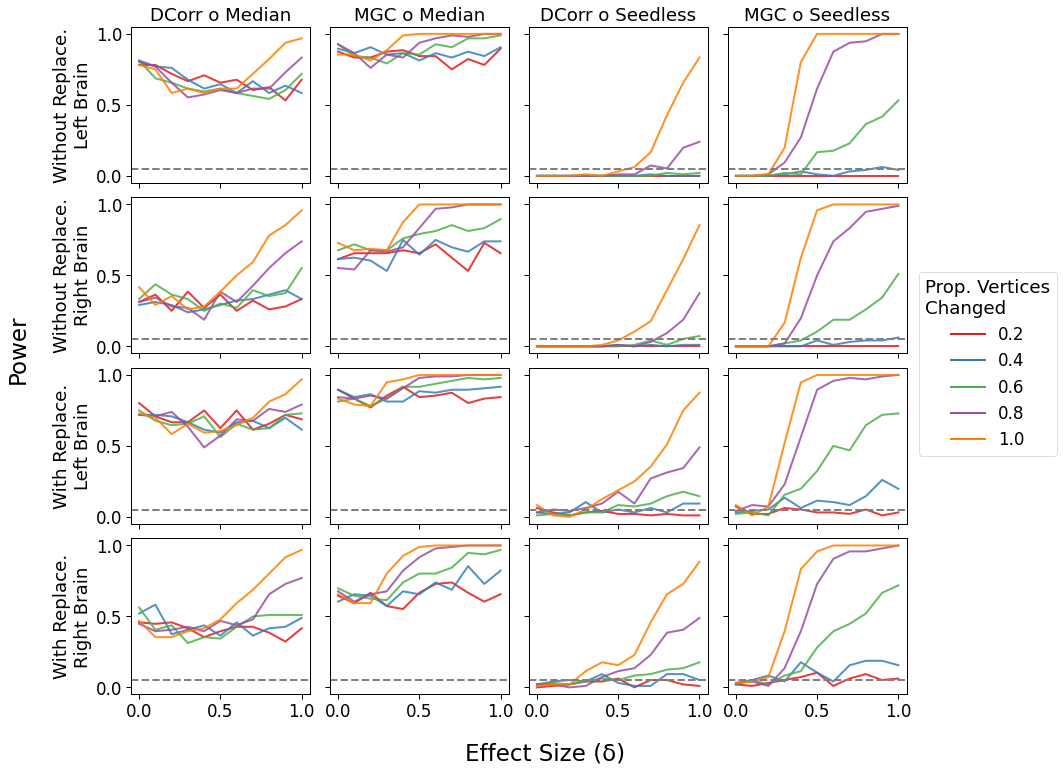

In [95]:
sns.set_context('paper', font_scale=1.9, rc={"lines.linewidth": 2})
fig, ax = plt.subplots (nrows=4, ncols=4, figsize=(12, 10), constrained_layout=True, sharex=True, sharey=True)

for row, df in enumerate(dfs):
    for col, col_name in enumerate(col_names):
        tmp = df[["n_verts_perterbed", "delta", col_name]]
        sns.lineplot(
            x = "delta",
            y=col_name,
            hue = "n_verts_perterbed",
            data = tmp,
            ax = ax[row, col],
            palette=['#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00'],
            alpha=0.85
        )
        
        # Set row title
        if col == 0:
            ax[row, col].set_ylabel(row_titles[row])
            
        # Set col title
        if row == 0:
            ax[row, col].set_title(col_titles[col_name])
        
        #ax[row, col].set_xticks([])
        #ax[row, col].set_yticks([])
        ax[row, col].set_yticks([0, 0.5,  1])
        ax[row, col].set_xlabel("")
        
        ax[row, col].axhline(0.05, c='gray', ls='--')
            
for i in range(4):
    for j in range(4):   
        handles, labels = ax[i, j].get_legend_handles_labels() 
        #labels[0] = "Prop. Vertices\nChanged" # Rename the title of legend
        ax[i, j].legend().remove()

legend = fig.legend(
    handles=handles,
    labels=["0.2", "0.4", "0.6", "0.8", "1.0"],
    ncol = 1, 
    loc='center right',
    bbox_to_anchor=(1.175, .5),
    bbox_transform=plt.gcf().transFigure,
    title = "Prop. Vertices\nChanged"
)

fig.text(-0.05, .48, "Power", rotation="vertical", fontsize=23)
fig.text(.48, -0.05, "Effect Size (δ)", fontsize=23)

In [96]:
fig.savefig("./figures/power_curve_final.pdf", bbox_inches='tight')
fig.savefig("./figures/power_curve_final.png", bbox_inches='tight', dpi=300)